## Hotel booking cancellation: Exploratory analysis and prediction

Dataset:
<a href="https://www.kaggle.com/jessemostipak/hotel-booking-demand" target="_blank">Hotel booking demand</a>

Objectives:  
* Perform data preparation, visualisation and modeling in Python with reference kernels <a href=" * https://www.kaggle.com/vssseel/eda-various-ml-models-and-nn-with-roc-curves" target="_blank">[1]</a> <a href=" https://www.kaggle.com/marcuswingen/eda-of-bookings-and-ml-to-predict-cancelations " target="_blank">[2]</a> <a href=" https://www.kaggle.com/jessemostipak/hotel-booking-demand" target="_blank">[3]</a>.
* Apply decision tree, logistic regression, random forest and XGboost algorithms 
* Identify key features that can predict hotel booking cancellations


In [1]:
# Setup 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc, classification_report, recall_score, precision_score, f1_score

# Display settings
sns.set(style = "white")
sns.color_palette("colorblind")
pd.set_option("display.max_columns", 40)

In [2]:
# Load data
df = pd.read_csv("../test1/hotel_bookings.csv")
df.head()
df.shape

(119390, 32)

### Data preparation

In [3]:
print("# of NaN in each columns:", df.isnull().sum(), sep='\n')

# of NaN in each columns:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                          

In [4]:
# Replace missing values in children, country,
nan_replacements = {"children": 0,"country": "Unknown"}
data_cln = df.fillna(nan_replacements)

# Replace undefined to SC in meal
data_cln["meal"].replace("Undefined", "SC", inplace=True)

# Transform agent, company 
data_cln['from_agent'] = data_cln['agent'].apply(lambda x: '1' if x>0 else '0')
data_cln['from_company'] = data_cln['company'].apply(lambda x: '1' if x>0 else '0')

# New variable
data_cln.loc[data_cln['reserved_room_type'] == data_cln['assigned_room_type'], 'has_roomtypechange'] = '0'  
data_cln.loc[data_cln['reserved_room_type'] != data_cln['assigned_room_type'], 'has_roomtypechange'] = '1'
data_cln['is_waitlisted'] = data_cln['days_in_waiting_list'].apply(lambda x: '1' if x>0 else '0')
data_cln['total_cb'] = data_cln['children'] + data_cln['babies']
data_cln['has_children'] = data_cln['total_cb'].apply(lambda x: '1' if x>0 else '0')
data_cln['total_people'] = data_cln['children'] + data_cln['babies'] + data_cln['adults']
data_cln['total_nights'] = data_cln['stays_in_week_nights'] + data_cln['stays_in_weekend_nights']

In [5]:
data_cln.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'from_agent',
       'from_company', 'has_roomtypechange', 'is_waitlisted', 'total_cb',
       'has_children', 'total_people', 'total_nights'],
      dtype='object')

In [6]:
# Drop obs with no guests
zero_guests = list(data_cln.loc[data_cln["adults"]
                   + data_cln["children"]
                   + data_cln["babies"]==0].index)
data_cln.drop(data_cln.index[zero_guests], inplace=True)
data_cln.shape


(119210, 40)

In [7]:
# Drop obs with no nights
zero_nights = list(data_cln.loc[data_cln["stays_in_weekend_nights"]
                   + data_cln["stays_in_week_nights"]==0].index)
data_cln.drop(data_cln.index[zero_nights], inplace=True)
data_cln.shape

(118565, 40)

### Data exploration

In [8]:
#subset by hotel type
ch = data_cln.loc[(data_cln["hotel"] == "City Hotel")]
rh = data_cln.loc[(data_cln["hotel"] == "Resort Hotel")]

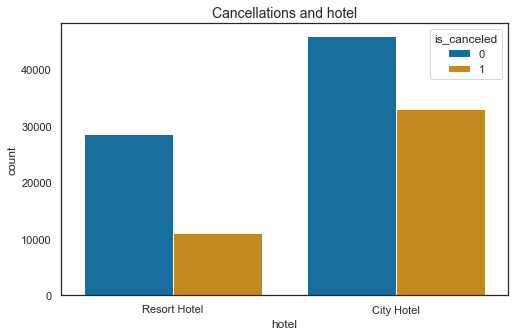

In [9]:
# Cancellations by hotel
plt.figure(figsize = (8,5))
plt.title("Cancellations and hotel", fontdict = {'fontsize': 14})
ax = sns.countplot(x = "hotel", hue = 'is_canceled', data = data_cln, palette= 'colorblind')

The proportion of cancellations in city hotels is higher than resort hotel.

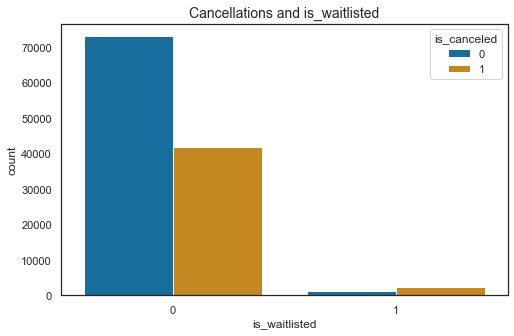

In [10]:
# Cancellations and is_waitlisted
plt.figure(figsize = (8,5))
plt.title("Cancellations and is_waitlisted", fontdict = {'fontsize': 14})
ax = sns.countplot(x = "is_waitlisted", hue = 'is_canceled', data = data_cln, palette= 'colorblind')

Majority of the bookings in are not waitlisted. The porportion of cancellations in waitlisted bookings are higher than  those that are not waitlisted. 

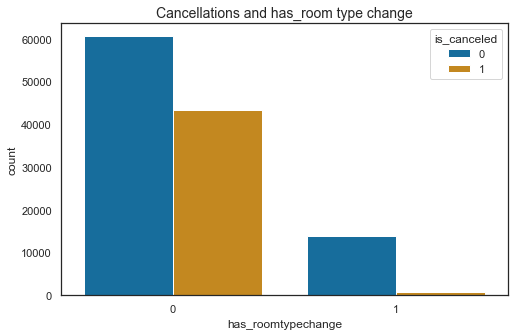

In [11]:
# Cancellations and has_roomtypechanges
plt.figure(figsize = (8,5))
plt.title("Cancellations and has_room type change", fontdict = {'fontsize': 14})
ax = sns.countplot(x = "has_roomtypechange", hue = 'is_canceled', data = data_cln, palette= 'colorblind')

Bookings that have room type changes (assigned a different room than reserved due to hotel operation) have a lower proportion of cancellations. 

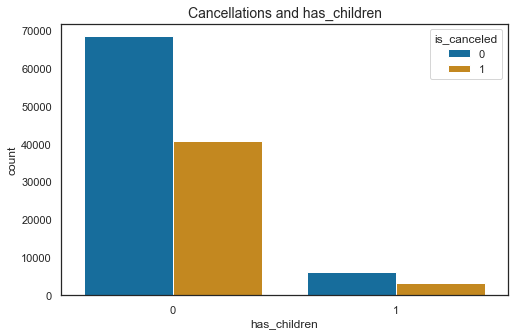

In [12]:
# Cancellations and has_children
plt.figure(figsize = (8,5))
plt.title("Cancellations and has_children", fontdict = {'fontsize': 14})
ax = sns.countplot(x = "has_children", hue = 'is_canceled', data = data_cln, palette= 'colorblind')

Majority of the hotel bookings are adults without children(babies). 

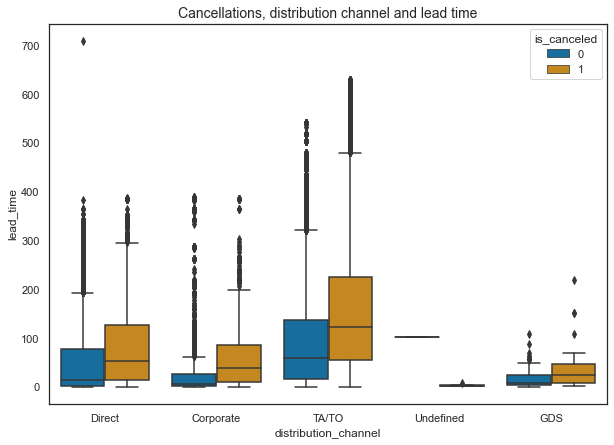

In [13]:
# Cancellations, distribution channel and lead time
plt.figure(figsize = (10,7))
plt.title("Cancellations, distribution channel and lead time", fontdict = {'fontsize': 14})
sns.boxplot(x = "distribution_channel", y = "lead_time", data = data_cln, hue = "is_canceled", palette = 'colorblind')

Aside from undefined group, canceled hotel bookings have a higher median lead time across the distribution channels. In comparing non-canceled bookings, TA/TO distribution channel has the longest lead time suggesting that bookings through this channel are placed more in advanced compared to the other channels. 

In [14]:
# Cancellation proportion by month and hotel 
# Prepare data
res_book_per_month = data_cln.loc[(data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = data_cln.loc[(data_cln["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = data_cln.loc[(data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = data_cln.loc[(data_cln["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)


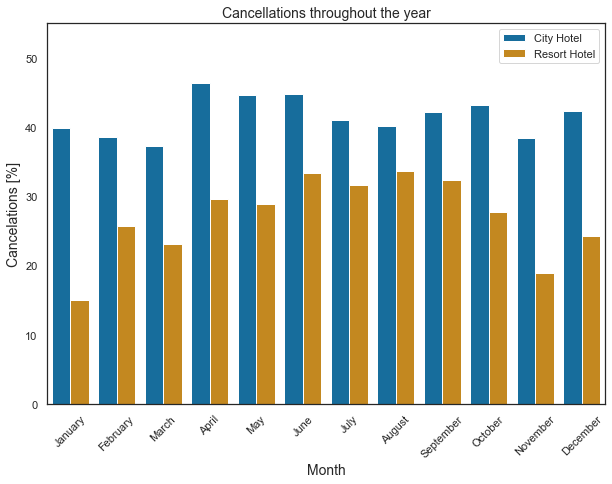

In [15]:
#plot
plt.figure(figsize=(10, 7))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data, palette = 'colorblind')
plt.title("Cancellations throughout the year", fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=14)
plt.legend(loc="upper right")
plt.ylim(0,55)
plt.show()

Resort hotels have a higher proportion of cancellations from June to September, coinciding with the northern hemisphere summer months. City hotels have higher proportion of cancellations in the second quarter of the year. 

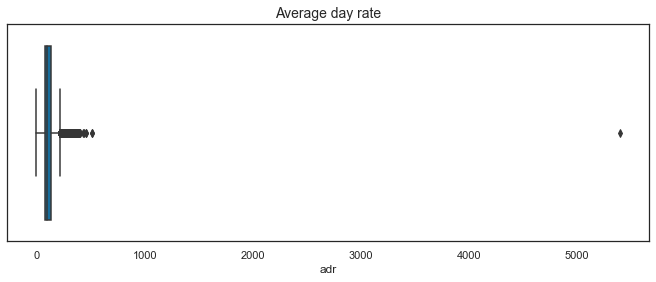

In [16]:
# Average day rate [ADR]
plt.figure(figsize = (11.5,4))
plt.title("Average day rate", fontdict = {'fontsize': 14})
sns.boxplot(x = "adr", data = data_cln, palette = 'colorblind')

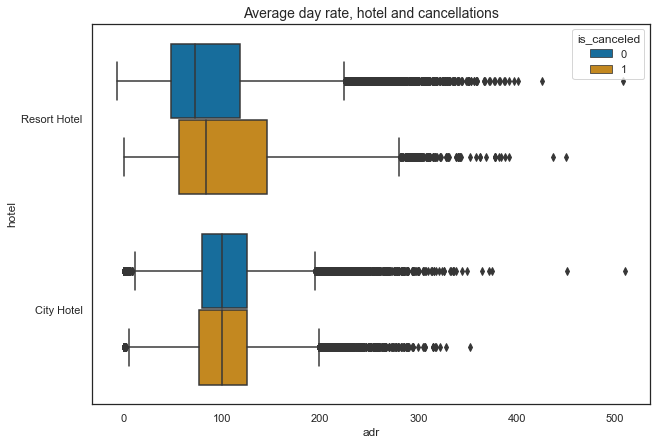

In [17]:
# ADR 
# Drop ob with 5400
data_cln2 = data_cln[data_cln.adr != 5400]
plt.figure(figsize = (10,7))
plt.title("Average day rate, hotel and cancellations", fontdict = {'fontsize': 14})
sns.boxplot(x = "adr", y = "hotel", hue = "is_canceled", data = data_cln2, palette = 'colorblind')

The median ADR of city hotels is higher than resort hotels, however resort hotels have a wider range of rates. For resort hotels, the canceled bookings had a higher median ADR than non-canceled bookings. 

In [18]:
# Cancellations by deposit type
dtc = data_cln.groupby("deposit_type")["is_canceled"].value_counts()

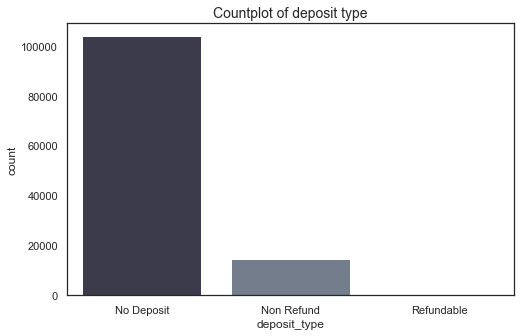

In [19]:
# # Deposit type
plt.figure(figsize = (8,5))
plt.title("Countplot of deposit type", fontdict = {'fontsize':14})
ax = sns.countplot(x = "deposit_type", data = data_cln, palette = 'bone', order=["No Deposit", "Non Refund", "Refundable"])

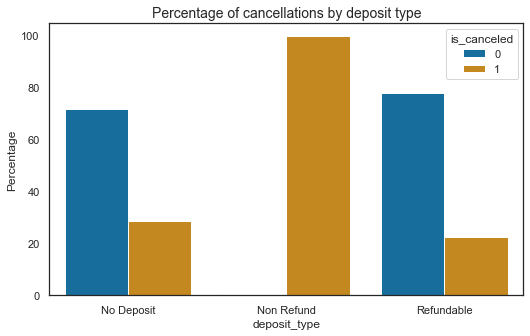

In [20]:
# Percentage of cancellations by deposit type
seg_counts = (data_cln.groupby(['deposit_type'])['is_canceled']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('deposit_type'))
plt.figure(figsize = (8.5,5))
plt.title("Percentage of cancellations by deposit type", fontdict = {'fontsize': 14})
p = sns.barplot(x="deposit_type", y="Percentage", hue="is_canceled", data=seg_counts, palette = 'colorblind')

More than 99% of the non refund bookings in the dataset were canceled, which is odd. 

In [21]:
# Select hotel customers(not canceled/checkout)
data_cust = data_cln.loc[(data_cln["is_canceled"] == 0)]
# Hotel and segment 
data_cust.groupby("hotel")["market_segment"].value_counts().rename("count")

hotel         market_segment
City Hotel    Online TA         24076
              Offline TA/TO      9485
              Direct             4989
              Groups             4327
              Corporate          2317
              Complementary       467
              Aviation            182
Resort Hotel  Online TA         11332
              Offline TA/TO      6269
              Direct             5556
              Groups             3324
              Corporate          1923
              Complementary       166
Name: count, dtype: int64

Text(0.5, 1.05, 'Countplot of segment by hotel')

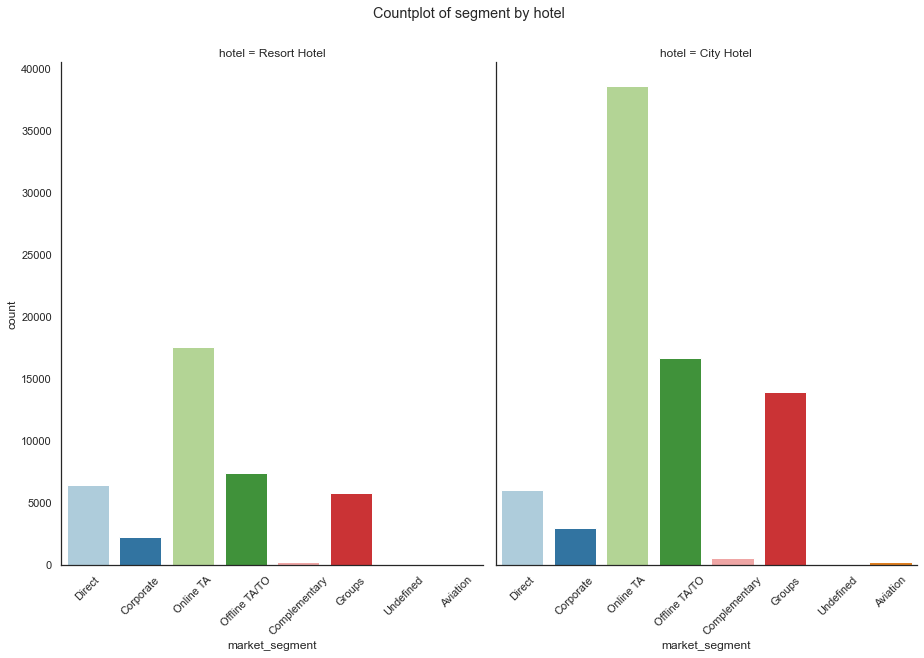

In [22]:
# Plot
g = sns.catplot(x="market_segment", col="hotel",
    data=data_cln, kind="count",
    height=8, aspect=.8, palette = 'Paired' )
g.set_xticklabels(rotation=45)
g.fig.suptitle("Countplot of segment by hotel", fontdict = {'fontsize':14}, y=1.05)

Resort hotel does not have bookings from the aviation market segment unlike city hotel. The online TA market segment make up the largest segment in both city hotel and resort hotel. 

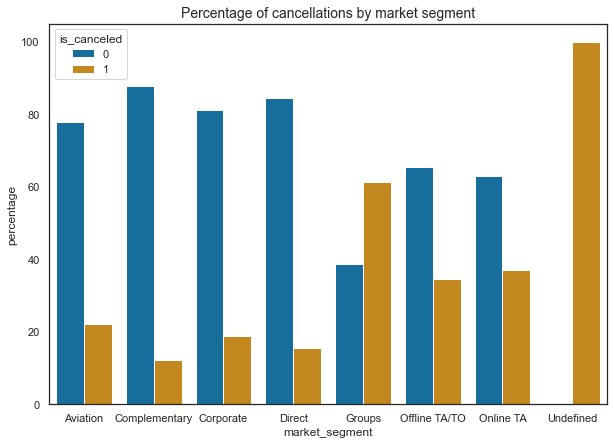

In [23]:
# Percentage of cancellations by market segment
seg_counts = (data_cln.groupby(['market_segment'])['is_canceled']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('market_segment'))
plt.figure(figsize = (10,7))
plt.title("Percentage of cancellations by market segment", fontdict = {'fontsize': 14})
p = sns.barplot(x="market_segment", y="percentage", hue="is_canceled", data=seg_counts, palette = 'colorblind')

The undefined market segment has the least count and all obs in the group are canceled. 

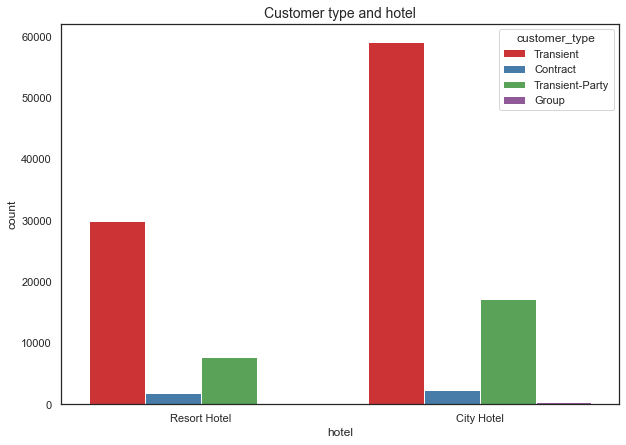

In [24]:
# Customer type and hotel 
plt.figure(figsize = (10,7))
plt.title("Customer type and hotel", fontdict = {'fontsize': 14})
ax = sns.countplot(x = "hotel", hue = 'customer_type', data = data_cln, palette = 'Set1')


Transient customers make up the largest proportion for both resort hotel and city hotel, while the group customers are the smallest proportion. 

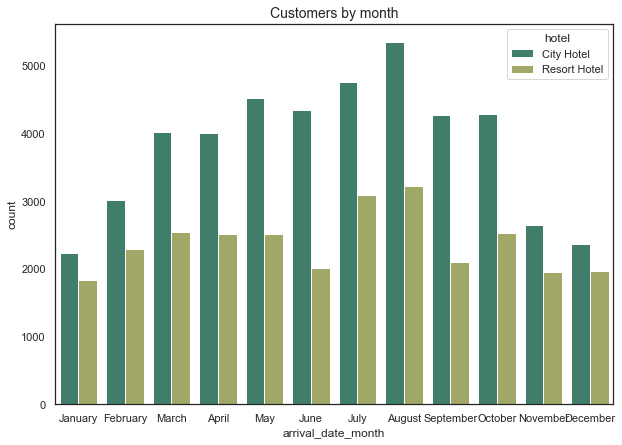

In [25]:
# Customers by month and hotel
# Prepare data
cust_m = data_cust[["hotel", "arrival_date_month"]].sort_values("arrival_date_month")
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
cust_m["arrival_date_month"] = pd.Categorical(cust_m["arrival_date_month"], categories=ordered_months, ordered=True)
# Plot
plt.figure(figsize =(10,7))
plt.title("Customers by month", fontdict={'fontsize': 14})
ax = sns.countplot(x = "arrival_date_month", hue = 'hotel', data = cust_m, palette = 'gist_earth')

City hotel and resort hotel recieved most customers in August, followed by July. 

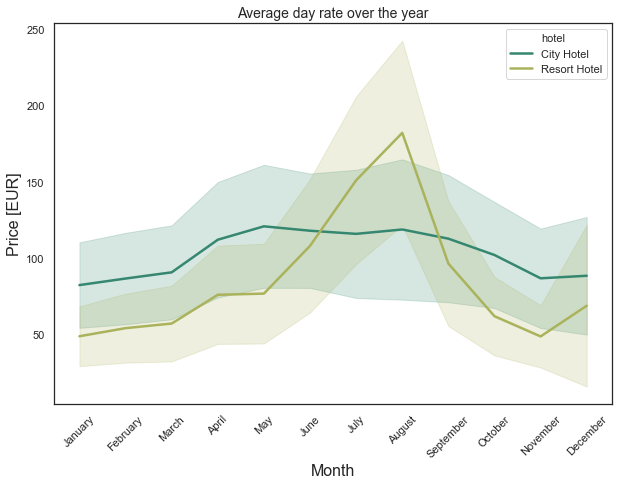

In [26]:
# ADR, month, hotel
# Select non-cancelled customers
room_price_m = data_cust[["hotel", "arrival_date_month", "adr"]].sort_values("arrival_date_month")
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
room_price_m["arrival_date_month"] = pd.Categorical(room_price_m["arrival_date_month"], categories=ordered_months, ordered=True)
# Plot
plt.figure(figsize=(10, 7))
sns.lineplot(x = "arrival_date_month", y="adr", hue="hotel", data=room_price_m, 
            hue_order = ["City Hotel", "Resort Hotel"], ci="sd", size="hotel", palette = 'gist_earth', sizes=(2.5, 2.5))
plt.title("Average day rate over the year", fontsize=14)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price [EUR]", fontsize=16)
plt.show()


The ADR of resort hotel is the highest in August, which is the month that the resort hotel recieves the most customer (shown in the previous section).  The changes in city hotel ADR throughout the year is smaller as compared to resort hotel. 

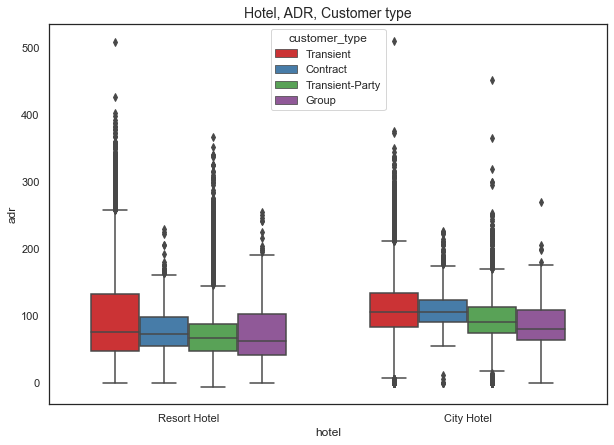

In [27]:
# Hotel, ADR, Customer type 
plt.figure(figsize = (10,7))
plt.title("Hotel, ADR, Customer type", fontdict = {'fontsize': 14})
sns.boxplot(x = "hotel", y = "adr", hue = "customer_type", data = data_cust, palette = 'Set1', width= 0.7)


Group customers pay the lowest ADR in both city hotel and resort hotel. 

In [28]:
# Proportion of distribution channel by hotel
dc = data_cust.groupby("hotel")["distribution_channel"].value_counts().rename("count")
dc2 = dc / dc.groupby(level=0).sum()
dc2

hotel         distribution_channel
City Hotel    TA/TO                   0.820300
              Direct                  0.119691
              Corporate               0.056606
              GDS                     0.003403
Resort Hotel  TA/TO                   0.685439
              Direct                  0.225691
              Corporate               0.088834
              Undefined               0.000035
Name: count, dtype: float64

Resort hotel does have a GDS channel unlike city hotel. 

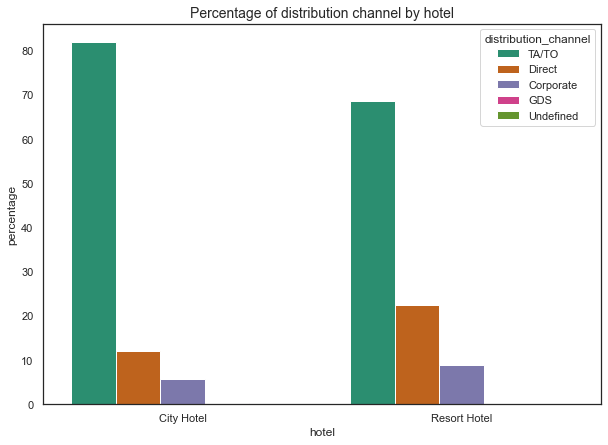

In [29]:
# Plot
dc_counts = (data_cust.groupby(['hotel'])['distribution_channel']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('hotel'))
plt.figure(figsize = (10,7))
plt.title("Percentage of distribution channel by hotel", fontdict = {'fontsize': 14})
p = sns.barplot(x="hotel", y="percentage", hue="distribution_channel", data=dc_counts, palette = 'Dark2')

TA/TO makes up the largest proportion of distribution channels in both city hotel and resort hotel. As compared to city hotel, resort hotel has a larger proportion of direct and corporate channels. 

### Prediction

In [30]:
# Check correlation of numeric variables
cancel_corr = data_cln.corr()["is_canceled"]
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.292618
total_of_special_requests         0.235274
required_car_parking_spaces       0.195867
booking_changes                   0.145050
previous_cancellations            0.109823
is_repeated_guest                 0.083797
agent                             0.082276
adults                            0.057893
previous_bookings_not_canceled    0.057417
days_in_waiting_list              0.054128
adr                               0.045495
total_people                      0.044671
babies                            0.032537
stays_in_week_nights              0.025216
company                           0.022375
total_nights                      0.018218
arrival_date_year                 0.016196
arrival_date_week_number          0.008251
arrival_date_day_of_month         0.006275
children                          0.004959
total_cb                          0.002890
stays_in_weekend_nights           0.001559
Name: is_canceled, dtype: float64

In [31]:
# Check reservation_status
data_cln.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             74413
1            Canceled              42949
             No-Show                1203
Name: reservation_status, dtype: int64

In [32]:
# Check deposit_type
deposit_mean_data = data_cln.groupby("deposit_type").mean()
deposit_mean_data

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_cb,total_people,total_nights
deposit_type,,,,,,,,,,,,,,,,,,,,,,,
No Deposit,0.285383,89.004546,2016.175182,27.132006,15.816150,0.970018,2.557686,1.866271,0.118724,0.009073,0.035212,0.042194,0.154841,0.246627,90.788242,189.129651,1.520741,103.817701,0.070895,0.651793,0.127797,1.994067,3.527704
Non Refund,0.993825,213.016123,2016.031698,27.455918,15.594648,0.621063,2.092075,1.811595,0.000617,0.000000,0.004391,0.411252,0.010635,0.012419,55.202651,179.189723,7.982436,89.978156,0.000069,0.001784,0.000617,1.812213,2.713139
Refundable,0.223602,151.993789,2016.142857,20.975155,23.409938,0.981366,2.850932,1.906832,0.031056,0.000000,0.024845,0.000000,0.018634,0.590062,189.625000,227.989362,9.645963,76.273168,0.124224,0.142857,0.031056,1.937888,3.832298


The feature reservation_status contains information of is_canceled. Majority of the bookings deposit type: Non Refund group is canceled and the group have higher previous cancellations but lower required_car_parking_spaces and total_of_special_requests compared to the groups, suggesting that there could be errors in this feature. Hence, reservation_status and deposit_type will not be used for modeling. 

As the company and agent features contain ID information, the transformed variables from_agent and from_company will be used for modeling. 

The variable has_children, total_people, total_nights and is_waitlisted is derived from the original variables so they will not be used in conjunction with their original variables in the model. 

arrival_date_month will be used instead of arrival_week_number 


In [33]:
# Data preparation 
# Select variables
num_features = ["lead_time","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","has_children",
                "is_repeated_guest", "previous_cancellations", "has_roomtypechange",
                "previous_bookings_not_canceled","from_agent","from_company", "days_in_waiting_list",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","customer_type"]
# Remove target variable
features = num_features + cat_features
X = data_cln.drop(["is_canceled"], axis=1)[features]
y = data_cln["is_canceled"]
# Preprocess numeric variable
num_transformer = SimpleImputer(strategy="constant")
# Preprocess categorical variables
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])
# Bundle preprocessing
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])
# Data spilt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)



In [34]:
# For evaluation 
def ROC(y_test, y_prob):
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

#### Decision Tree

In [35]:
dt_model = DecisionTreeClassifier(criterion= 'gini', max_features = 'auto', random_state=42)
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', dt_model)])
dt_pipeline.fit(X_train, y_train)
dt_pred = dt_pipeline.predict(X_test)
print("DT accuracy", accuracy_score(y_test, dt_pred))
print("DT", classification_report(y_test, dt_pred))

DT accuracy 0.8178802361540624
DT               precision    recall  f1-score   support

           0       0.86      0.85      0.85     22324
           1       0.75      0.76      0.76     13246

    accuracy                           0.82     35570
   macro avg       0.80      0.81      0.81     35570
weighted avg       0.82      0.82      0.82     35570



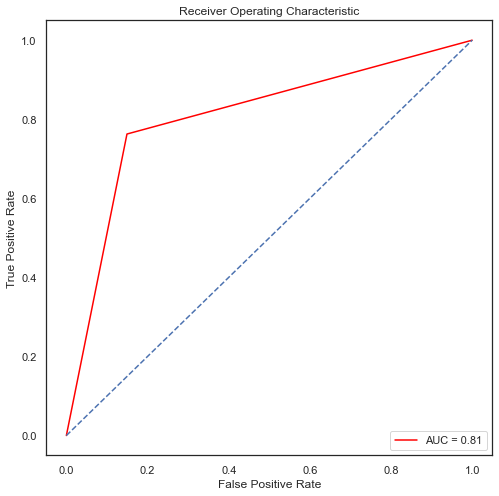

In [36]:
ROC(y_test, dt_pred)

In [37]:
for name, importance in zip(X_train.columns, dt_model.feature_importances_):
    print(name, importance)

lead_time 0.2131639956374029
arrival_date_day_of_month 0.09438082161566247
stays_in_weekend_nights 0.03171867096919062
stays_in_week_nights 0.05381322978692003
has_children 0.006765777743543269
is_repeated_guest 0.0013366526850387803
previous_cancellations 0.03445668410895091
has_roomtypechange 0.03312884869028903
previous_bookings_not_canceled 0.004479452255575329
from_agent 0.005244956349190384
from_company 0.0025133454528700598
days_in_waiting_list 0.004591865756010521
required_car_parking_spaces 0.022112812883204408
total_of_special_requests 0.08986269159981246
adr 0.14579575185047056
hotel 0.014185303745483675
arrival_date_month 0.003724941676384511
meal 0.007564628961973672
market_segment 0.006954928898299679
distribution_channel 0.004023637508942272
reserved_room_type 0.0049544720565925186
customer_type 0.004586394060739256


#### Logistic regression

In [38]:
lr_model = LogisticRegression(solver= "liblinear", random_state=42)
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', lr_model)])
lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)
print("LR accuracy", accuracy_score(y_test, lr_pred))
print("LR", classification_report(y_test, lr_pred))
print("ROC-AUC", roc_auc_score(y_test, lr_pred))

LR accuracy 0.7905257239246556
LR               precision    recall  f1-score   support

           0       0.81      0.88      0.84     22324
           1       0.76      0.65      0.70     13246

    accuracy                           0.79     35570
   macro avg       0.78      0.76      0.77     35570
weighted avg       0.79      0.79      0.79     35570

ROC-AUC 0.7613870944274679


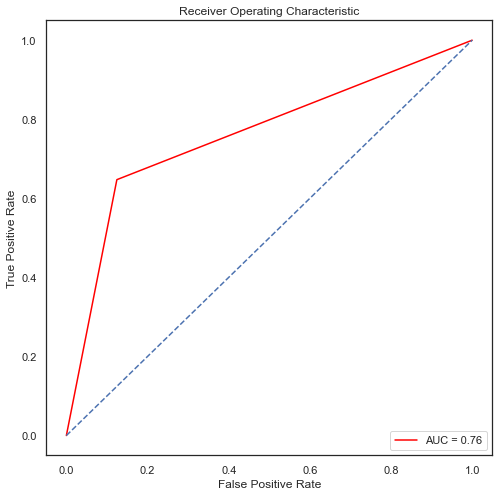

In [39]:
ROC(y_test, lr_pred)

In [40]:
# Coefficients
print(list(zip(X_train.columns.tolist(),lr_model.coef_[0])))

[('lead_time', 0.005385547471341919), ('arrival_date_day_of_month', -0.002063775321115105), ('stays_in_weekend_nights', -0.0248382545154053), ('stays_in_week_nights', 0.014781255790882518), ('has_children', 0.1498527133914896), ('is_repeated_guest', -1.0136785905309509), ('previous_cancellations', 2.9538511831521532), ('has_roomtypechange', -2.069635039656988), ('previous_bookings_not_canceled', -0.479644408855955), ('from_agent', -0.3210323267214572), ('from_company', -1.238091132594059), ('days_in_waiting_list', 0.000558973254991218), ('required_car_parking_spaces', -4.702846184848575), ('total_of_special_requests', -0.8160807330973863), ('adr', 0.0076996108120829425), ('hotel', -0.3885884836297116), ('arrival_date_month', -0.368986399835998), ('meal', 0.09610386353381481), ('market_segment', -0.3298041733552719), ('distribution_channel', 0.15600349749491824), ('reserved_room_type', 0.21427935814380755), ('customer_type', 0.14579624351799822)]


#### Random forest

In [41]:
rf_model = RandomForestClassifier(random_state=42)
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model)])
rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
print("RF accuracy", accuracy_score(y_test, rf_pred))
print("RF", classification_report(y_test, rf_pred))
print("ROC-AUC", roc_auc_score(y_test, rf_pred))

RF accuracy 0.8602473994939556
RF               precision    recall  f1-score   support

           0       0.87      0.92      0.89     22324
           1       0.84      0.77      0.80     13246

    accuracy                           0.86     35570
   macro avg       0.86      0.84      0.85     35570
weighted avg       0.86      0.86      0.86     35570

ROC-AUC 0.8410933195480026


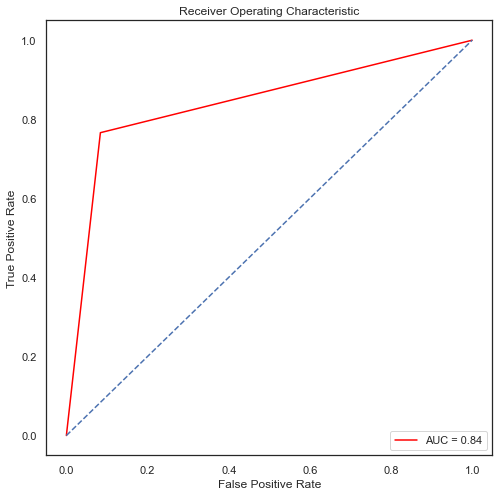

In [42]:
ROC(y_test, rf_pred)

In [43]:
for name, importance in zip(X_train.columns, rf_model.feature_importances_):
    print(name, importance)

lead_time 0.18452849905162394
arrival_date_day_of_month 0.09371862356448799
stays_in_weekend_nights 0.0340989356405781
stays_in_week_nights 0.05493109683607578
has_children 0.006398451990602784
is_repeated_guest 0.002479172071307855
previous_cancellations 0.049307606033476246
has_roomtypechange 0.04148251943343707
previous_bookings_not_canceled 0.004507517006926129
from_agent 0.006046723414922617
from_company 0.004609242652132244
days_in_waiting_list 0.0073056903503487276
required_car_parking_spaces 0.023888525297605316
total_of_special_requests 0.0758932024473615
adr 0.12961974526888007
hotel 0.0075880215428875426
arrival_date_month 0.009203502512330354
meal 0.006793851589149909
market_segment 0.007464594675706286
distribution_channel 0.005269072277430785
reserved_room_type 0.005555003088701656
customer_type 0.004335457163854676


#### XGB

In [44]:
xgb_model = XGBClassifier(random_state=42)
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_model)])
xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)
print("XGB accuracy", accuracy_score(y_test, xgb_pred))
print("XGB", classification_report(y_test, xgb_pred))
print("ROC-AUC", roc_auc_score(y_test, xgb_pred))

XGB accuracy 0.8394995782963172
XGB               precision    recall  f1-score   support

           0       0.84      0.91      0.88     22324
           1       0.83      0.72      0.77     13246

    accuracy                           0.84     35570
   macro avg       0.84      0.81      0.82     35570
weighted avg       0.84      0.84      0.84     35570

ROC-AUC 0.81437174016596


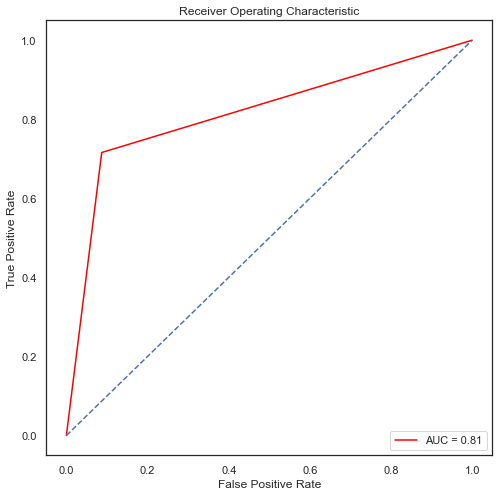

In [45]:
ROC(y_test, xgb_pred)

In [46]:
for name, importance in zip(X_train.columns, xgb_model.feature_importances_):
    print(name, importance)

lead_time 0.017381836
arrival_date_day_of_month 0.003861543
stays_in_weekend_nights 0.003972544
stays_in_week_nights 0.0054247673
has_children 0.0043291915
is_repeated_guest 0.0036404484
previous_cancellations 0.16996957
has_roomtypechange 0.12282535
previous_bookings_not_canceled 0.026003594
from_agent 0.0056923544
from_company 0.013856937
days_in_waiting_list 0.0128981145
required_car_parking_spaces 0.10667894
total_of_special_requests 0.045760177
adr 0.006320747
hotel 0.009716991
arrival_date_month 0.0
meal 0.005425619
market_segment 0.0054944754
distribution_channel 0.0056773624
reserved_room_type 0.0053465283
customer_type 0.0047351914


#### Random forest - part 2

Multiple feature sets were tested (with and without: total people, week nights, weekend nights, customer type) and the metrics were similar with accuracy in between .85 to .85.9 i.e., lower than the first RF model. 

In [47]:
# Random forest with a different set of features
# Remove days_in_week_nights, days_in_weekend_nights, add total people
num_features_2 = ["lead_time","arrival_date_day_of_month",
                "total_nights","has_children", "total_people",
                "is_repeated_guest", "previous_cancellations", "has_roomtypechange",
                "previous_bookings_not_canceled","from_agent","from_company", "days_in_waiting_list",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features_2 = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","customer_type"]

# Bundle preprocessing for numerical and categorical features
preprocessor_2 = ColumnTransformer(transformers=[("num", num_transformer, num_features_2),
                                               ("cat", cat_transformer, cat_features_2)])

# Define dataset
features_2 = num_features_2 + cat_features_2
y2 = data_cln["is_canceled"]
X2 = data_cln.drop(["is_canceled"], axis=1)[features_2]

# Split data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify = y)

In [48]:
# Define model
rf_model2 = RandomForestClassifier(random_state=42)
rf2_pipeline = Pipeline(steps=[('preprocessor', preprocessor_2),
                              ('model', rf_model2)])
rf2_pipeline.fit(X_train2, y_train2)
rf2_pred = rf2_pipeline.predict(X_test2)

# Results
print("RF accuracy", accuracy_score(y_test2, rf2_pred))
print("RF", classification_report(y_test2, rf2_pred))
print("ROC-AUC", roc_auc_score(y_test2, rf2_pred))


RF accuracy 0.8592071970761878
RF               precision    recall  f1-score   support

           0       0.87      0.91      0.89     22324
           1       0.84      0.77      0.80     13246

    accuracy                           0.86     35570
   macro avg       0.85      0.84      0.85     35570
weighted avg       0.86      0.86      0.86     35570

ROC-AUC 0.8402953146640327


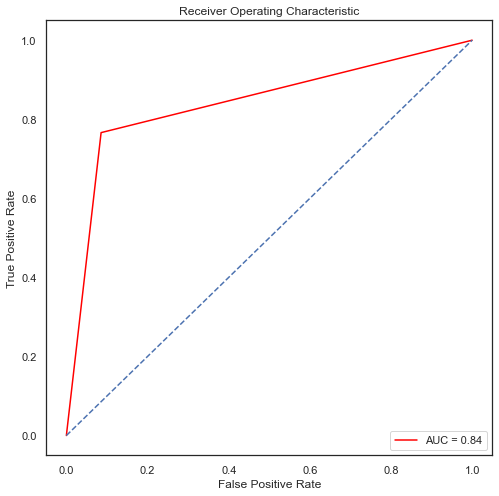

In [49]:
ROC(y_test, rf2_pred)

Algorithm evaluation: 
Random forest algorithm outperformed decision tree, logistic regression and XGBoost in terms of accuracy, precision, recall, f1 and AUC. 

Model evaluation: 
In comparision with RF1, RF2 has a similar accuracy, f1, precision(1), recall(1) and AUC score.  

Important features:
RF model 1 shows that the five most important variables are lead_time, adr, arrival_date_day_of_month, total_of_special_requests and stays_in_week_nights, respectively. 

Effect of 5 most important features on hotel booking cancellation:
1. Bookings that are made close to the arrival dates have a lower cancellation rate, while bookings made a year in advanced have a high cancellation rate. 
2. Bookings with higher daily average daily rate have a higher cancellation rate. 
3. Bookings for arrival dates towards after 17th day of the month have a lower cancellation rate than the earlier part of the month. 
4. Bookings with one or more total special requests have a lower cancellation rate than bookings without any special requests.
5. Bookings with 10 to 24 weekday night stays have a higher cancellation rate than bookings with less than 10 weekday night stays. 


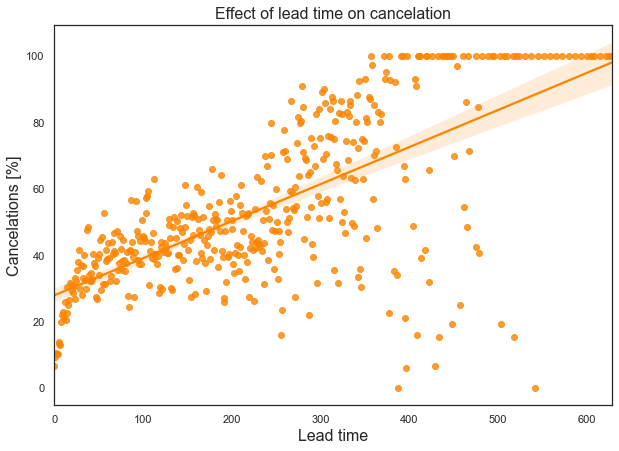

In [50]:
# Lead time 
# Group data 
lead_cancel_data = data_cln.groupby("lead_time")["is_canceled"].describe()
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

# Plot
plt.figure(figsize=(10, 7))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100, color="#fb8500")
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

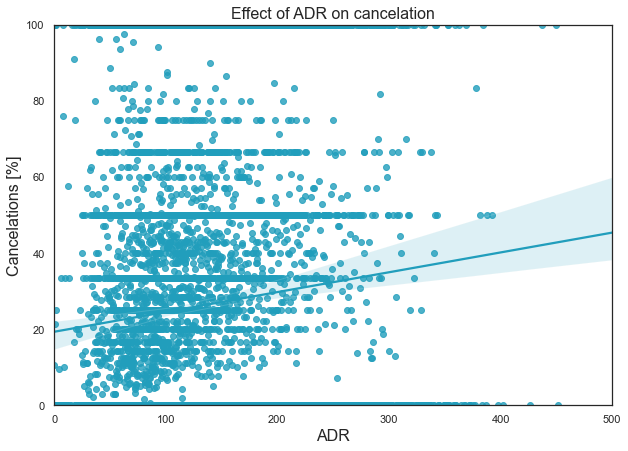

In [51]:
# ADR 
# Group data 
adr_cancel_data = data_cln.groupby("adr")["is_canceled"].describe()

# Plot
plt.figure(figsize=(10, 7))
sns.regplot(x=adr_cancel_data.index, y=adr_cancel_data["mean"].values * 100, color="#219ebc")
plt.title("Effect of ADR on cancelation", fontsize=16)
plt.xlabel("ADR", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.xlim(0,500)
plt.ylim(0,100)
plt.show()

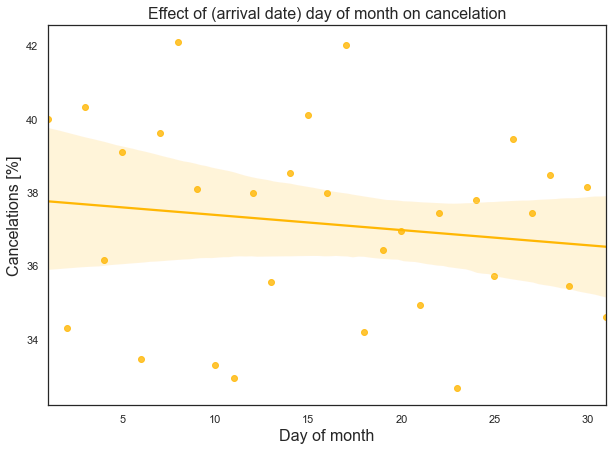

In [52]:
# arrival_date_day_of_month
# Group data 
dm_cancel_data = data_cln.groupby("arrival_date_day_of_month")["is_canceled"].describe()

# Plot
plt.figure(figsize=(10, 7))
sns.regplot(x=dm_cancel_data.index, y=dm_cancel_data["mean"].values * 100, color="#ffb703")
plt.title("Effect of (arrival date) day of month on cancelation", fontsize=16)
plt.xlabel("Day of month", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

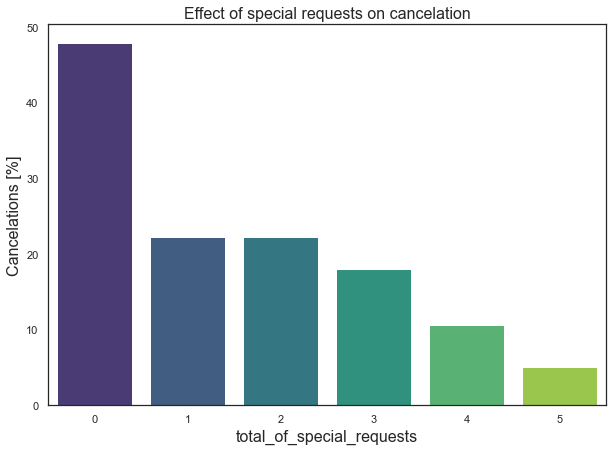

In [53]:
# total_of_special_requests
sp_cancel_data = data_cln.groupby("total_of_special_requests")["is_canceled"].describe()

# Plot
plt.figure(figsize=(10, 7))
sns.barplot(x=sp_cancel_data.index, y=sp_cancel_data["mean"] * 100, palette="viridis" )
plt.title("Effect of special requests on cancelation", fontsize=16)
plt.xlabel("total_of_special_requests", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

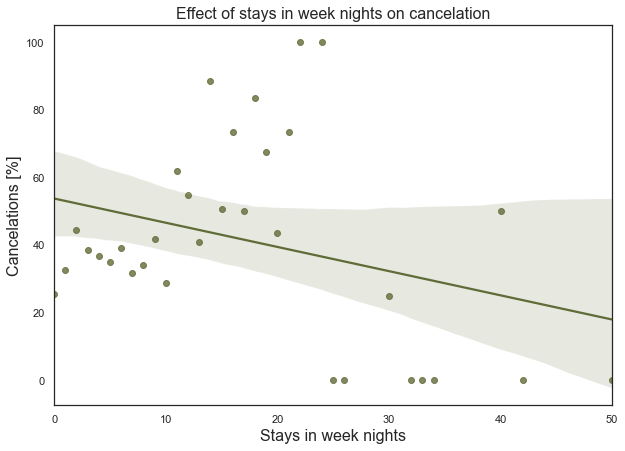

In [54]:
# stays_in_week_nights
wn_cancel_data = data_cln.groupby("stays_in_week_nights")["is_canceled"].describe()

# Plot
plt.figure(figsize=(10, 7))
sns.regplot(x=wn_cancel_data.index, y=wn_cancel_data["mean"].values * 100, color="#606c38")
plt.title("Effect of stays in week nights on cancelation", fontsize=16)
plt.xlabel("Stays in week nights", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()